In [38]:
import cv2
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm.auto import tqdm
import os
if Path('.').resolve().name != 'Arena':
    os.chdir('../Arena')
from analysis.predictors.tongue_out import TongueTrainer
from analysis.strikes.loader import Loader
from config import load_configuration
from db_models import ORM, Video, Experiment, Block, Trial, Strike

In [39]:
MAIN_FOLDER = '/media/sil2/Data/regev/datasets/predictive_tongues'

In [60]:
circle_speed_dict = {3: 2, 6: 4, 8: 6, 11: 8, 17: 10, 23: 12}

def get_bug_speed(tr, movement_type):
    bug_speed = None
    if tr.bug_trajectory is not None:
        bug_traj = pd.DataFrame(tr.bug_trajectory)
        dx = np.sqrt(bug_traj.x.diff() ** 2 + bug_traj.y.diff() ** 2)
        dx = round(dx)
        dx = dx[dx>0]
        vc = pd.Series(dx).value_counts(normalize=True)
        if movement_type in ['low_horizontal', 'low_horizontal_noise']:
            bug_speed = 6
        elif movement_type in ['jump_up', 'accelerate', 'accelerate_bad', 'rect_tunnel']:
            bug_speed = 5
        elif vc.iloc[0] > 0.5:
            bug_speed = vc.index[0]
            if movement_type == 'circle':
                bug_speed = circle_speed_dict.get(bug_speed, bug_speed)
    return bug_speed


def get_strikes_df(animal_id, movement_type):
    orm = ORM()
    sdf = []
    with orm.session() as s:
        orm_res = s.query(Strike, Trial, Block, Experiment).join(
            Trial, Trial.id == Strike.trial_id).join(
            Block, Block.id == Trial.block_id).join(
            Experiment, Experiment.id == Block.experiment_id).filter(
            Experiment.animal_id == animal_id,
            Experiment.start_time > '2023-04-18',
            Block.movement_type == movement_type,
        ).all()
        for strk, tr, blk, exp in orm_res:
            if tr.bug_trajectory is None or strk.is_climbing:
                continue
            sdf.append({'id': strk.id, 'bug_type': strk.bug_type, 'is_hit': strk.is_hit, 
                        'bug_speed': get_bug_speed(tr, movement_type),
                        'strike_x': strk.x, 'strike_y': strk.y, 'bug_x': strk.bug_x, 'bug_y': strk.bug_y})
    sdf = pd.DataFrame(sdf)
    return sdf


def get_tongue_frame_before_strike(fdf, threshold=0.85, counter_lim=2):
    counter = 0
    frames_before = None
    for i, j in enumerate(fdf.index[::-1]):
        if fdf.loc[j, 'prob'] >= threshold:
            counter += 1
        else:
            if counter >= counter_lim:
                frames_before = i + 1
                break
            counter = 0
    return frames_before


strikes_df = get_strikes_df('PV91', 'circle')
strikes_df.bug_speed.value_counts()

6    142
8     41
4     31
2     28
Name: bug_speed, dtype: int64

In [66]:
def run_predictive_tongue_analysis(animal_id, movement_type, is_cache=True):
    filename = f'{MAIN_FOLDER}/{animal_id}_{movement_type}.pkl'
    if is_cache and Path(filename).exists():
        with open(filename, 'rb') as f:
            res = pickle.load(f)
    else:
        strikes_df = get_strikes_df(animal_id, movement_type)
        conf = load_configuration('predict')
        tr = TongueTrainer(model_path=conf['tongue_out']['model_path'])
        res = {}
        for i, row in tqdm(strikes_df.iterrows(), total=len(strikes_df)):
            strike_id = int(row['id'])
            try:
                ld = Loader(strike_id, 'front')
                frames_df = []
                for frame_id, frame in ld.gen_frames_around_strike(n_frames_back=60):
                    label, prob = tr.predict(frame)
                    frames_df.append({'frame_id': frame_id, 'label': label, 'prob': prob})
                frames_df = pd.DataFrame(frames_df)
                res[strike_id] = (frames_df, row)
            except Exception as e:
                print(f'ERROR strike_id={strike_id}: {e}')
        with open(filename, 'wb') as f:
            pickle.dump(res, f)
    return res

strikes_res = run_predictive_tongue_analysis('PV163', 'circle')

model analysis.predictors.tongue_out load from: /data/Pogona_Pursuit/output/models/tongue_out/20230518_145847


  0%|          | 0/111 [00:00<?, ?it/s]

<AxesSubplot:xlabel='bug_speed', ylabel='frames_before'>

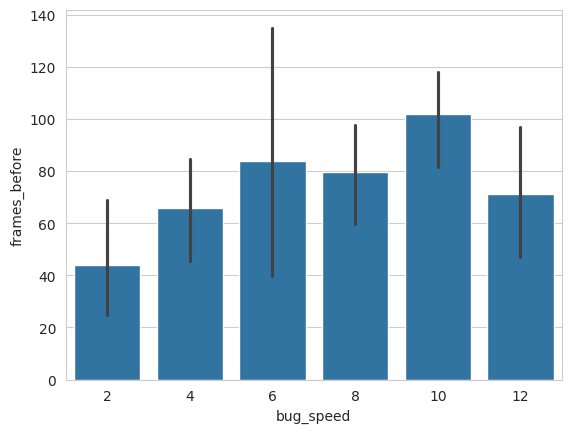

In [71]:
tdf = []
for strike_id, (frames_df, r) in strikes_res.items():
    dx = get_tongue_frame_before_strike(frames_df, threshold=0.8, counter_lim=3)
    tdf.append({'strike_id': strike_id, 'frames_before': dx, 'bug_speed': r.bug_speed})
tdf = pd.DataFrame(tdf)

sns.barplot(data=tdf, x='bug_speed', y='frames_before')

In [41]:
strikes_df = get_strikes_df('PV163', 'circle')

In [42]:
strikes_df

,id,bug_type,is_hit,bug_speed,strike_x,strike_y,bug_x,bug_y
0,3404,cockroach,False,8.0,1350.0,668.0,1120.628253,615.398184
1,3406,cockroach,False,8.0,1249.0,471.0,1171.289547,567.703248
2,3409,cockroach,False,8.0,1044.0,762.0,871.714943,665.106420
3,3411,green_beetle,False,7.0,771.0,619.0,872.783958,665.370216
4,3412,green_beetle,False,8.0,750.0,588.0,862.782693,662.736749
...,...,...,...,...,...,...,...,...
106,3512,green_beetle,True,3.0,847.0,714.0,903.704541,738.742065
107,3514,cockroach,True,3.0,932.0,738.0,970.229660,743.827836
108,3513,cockroach,True,3.0,929.0,735.0,898.088671,737.628942
109,3476,green_beetle,False,11.0,896.0,776.0,773.273936,679.894513


<AxesSubplot:>

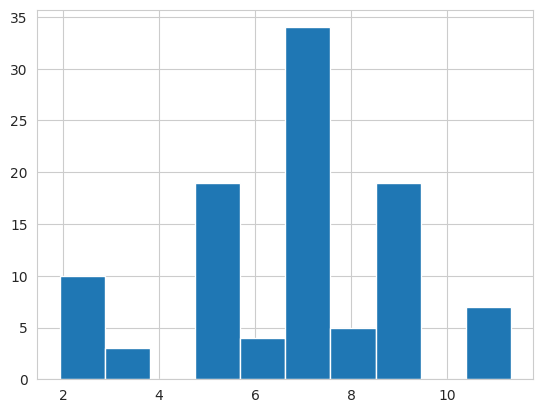

In [31]:
strikes_df.bug_speed.hist()